In [11]:
import CAE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2lab, lab2rgb


# Excercise 1

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split full dataset into training (80%), validation (10%) and test (10%)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


# Load the datasets into DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_model(model, train_loader, val_loader): 
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    num_epochs = 20
    trainning_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        trainning_loss.append(running_loss/len(train_loader))
        validation_loss.append(val_loss/len(val_loader))

    return trainning_loss, validation_loss
    
    # print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

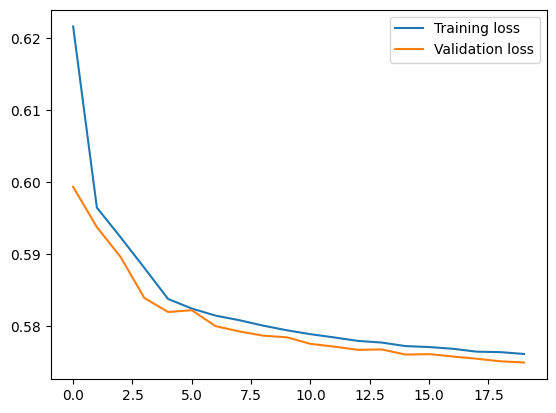

In [ ]:
model = CAE.ConvAutoencoder(3,[8,12,16],[16,12,3],1,1).to(device)
trainning_loss, validation_loss = train_model(model, train_loader, val_loader)

plt.plot(trainning_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()


In [6]:
test_error = 0.0
for images, _ in test_loader:
    images = images.to(device)
    outputs = model(images)
    
    test_error += nn.BCELoss()(outputs, images)

print(f"Test error: {test_error/len(test_loader)}")


Test error: 0.5764174461364746


Test error is 0.5764174461364746

# Exercise 2


In [7]:
test_image=next(iter(test_loader))[0][0].unsqueeze(0).to(device)
latent_space = model.encode(test_image)

print(latent_space.shape)


torch.Size([1, 16, 4, 4])


In [40]:
def calculate_test_loss(model, test_loader):
    test_loss = 0.0
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        loss = nn.BCELoss()(outputs, images)
        test_loss += loss.item()
    return test_loss/len(test_loader)   

The latent representation is in shape of [16,4,4] for above model.

In [ ]:
models=[]
reconstruction_errors=[]
latent_spaces=[]
for i in range(20,36,4):
    modelz = CAE.ConvAutoencoder(3,[8,12,i],[i,12,3],1,1).to(device)
    trainning_loss, validation_loss = train_model(model, train_loader, val_loader)
    
    reconstruction_errors.append(calculate_test_loss(modelz, test_loader))
    latent_space = modelz.encode(test_image)
    latent_spaces.append(latent_space)
    models.append(modelz)

In [9]:
for i in range(len(reconstruction_errors)):
    print(f"Model {i} with latent shape of {latent_spaces[i].shape} has a test error of {reconstruction_errors[i]}")

Model 0 with latent shape of torch.Size([1, 20, 4, 4]) has a test error of 0.6922046542167664
Model 1 with latent shape of torch.Size([1, 24, 4, 4]) has a test error of 0.6931101679801941
Model 2 with latent shape of torch.Size([1, 28, 4, 4]) has a test error of 0.6943248510360718
Model 3 with latent shape of torch.Size([1, 32, 4, 4]) has a test error of 0.6938032507896423


In [44]:
test_image=next(iter(test_loader))[0][0].unsqueeze(0).to(device)

In [45]:
model3=CAE.ConvAutoencoder(3,[8,16],[16,3],1,1).to(device)
trainning_loss, validation_loss = train_model(model3, train_loader, val_loader)
test_error = calculate_test_loss(model3, test_loader)
print(f"Model 3 with latent shape of {model3.encode(test_image).shape} has a test error of {test_error}")

Model 3 with latent shape of torch.Size([1, 16, 8, 8]) has a test error of 0.5616506457328796


In [ ]:
model5=CAE.ConvAutoencoder(3,[8,16,32,64],[64,32,16,3],1,1).to(device)
trainning_loss, validation_loss = train_model(model5, train_loader, val_loader)
test_error = calculate_test_loss(model5, test_loader)
print(f"Model 5 with latent shape of {model5.encode(test_image).shape} has a test error of {test_error}")

Model 5 with latent shape of torch.Size([1, 64, 2, 2]) has a test error of 0.5760579705238342


# Excercise 3

The best model among tested is the model with encoder layers of [3,8,16] and decoder layers of [16,3]. The latent space size under this circumstance is [1,16,8,8].

In [12]:
class ColorizationTransform:
    def __call__(self, img):
        img = np.array(img) / 255.0  
        lab_img = rgb2lab(img) 
        L = lab_img[:, :, 0] / 100.0 
        ab = lab_img[:, :, 1:] / 128.0 
        L_tensor = torch.tensor(L, dtype=torch.float32).unsqueeze(0) 
        ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)
        return L_tensor, ab_tensor

Seperate RGB channels to luminance and chrominance. Rehandle the source dataset.

In [46]:
class CustomCIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        self.cifar10 = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        img, _ = self.cifar10[idx]
        if self.transform:
            L, ab = self.transform(img)
        return L, ab


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply the transform to the dataset
transform = ColorizationTransform()

# Load CIFAR-10 dataset
full_dataset = CustomCIFAR10(root='./data', train=True, transform=transform, download=True)

# Split full dataset into training (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified


A new trainning method for this coloring application. New model is going to use greyscale image as input and output is chrominance. So the error calculation is modified accordingly.

In [14]:
def train_model_colorization(model, train_loader, val_loader): 
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  
    num_epochs = 20
    trainning_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for L, ab in train_loader:
            L = L.to(device)
            ab = ab.to(device)
            
            # Forward pass
            outputs = model(L)
            loss = criterion(outputs, ab)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for L, ab in val_loader:
                L = L.to(device)
                ab = ab.to(device)
                outputs = model(L)
                loss = criterion(outputs, ab)
                val_loss += loss.item()

        trainning_loss.append(running_loss/len(train_loader))
        validation_loss.append(val_loss/len(val_loader))

    return trainning_loss, validation_loss

New model input is 1x32x32. Output is 2x32x32.

In [15]:
model_colorization = CAE.ConvAutoencoder(1,[8,16],[16,2],1,1).to(device)
trainning_loss, validation_loss = train_model_colorization(model_colorization, train_loader, val_loader)

In [19]:
print(f"Model colorization with training loss: {trainning_loss[-1]}, validation loss: {validation_loss[-1]}")

Model colorization with training loss: 0.01059623325397824, validation loss: 0.010596198495477438


In [20]:
def reconstruct_lab_to_rgb(L, ab):
    L = L.squeeze(1) * 100.0  # Denormalize L to [0, 100]
    ab = ab * 128.0  # Denormalize ab to [-128, 128]
    lab = torch.cat([L.unsqueeze(-1), ab.permute(0, 2, 3, 1)], dim=-1).cpu().numpy()  # Combine
    rgb_images = [lab2rgb(lab_img) for lab_img in lab]  # Convert each image
    return np.stack(rgb_images)

In [47]:
def show_test_images(model_colorization, test_loader):
    for i, (L, ab) in enumerate(test_loader):
        if i >= 5:
            break
        L = L.to(device)
        ab = ab.to(device)
        outputs = model_colorization(L)

        original_images = reconstruct_lab_to_rgb(L, ab.detach())

        # Generate the greyscale images
        grey_images = L.squeeze().cpu().numpy()[0]
        grey_images = np.stack([grey_images]*3, axis=-1)

        outputs_images = reconstruct_lab_to_rgb(L, outputs.detach())

        fig, axes = plt.subplots(1, 3, figsize=(4, 2))
        axes[0].imshow(original_images[0])  # Display the first image in the batch
        axes[0].set_title('Original')
        axes[0].axis('off')
        axes[1].imshow(grey_images)  # Display the gret image in the batch
        axes[1].set_title('Greyscale')
        axes[1].axis('off')

        axes[2].imshow(outputs_images[0])  # Display the first image in the batch
        axes[2].set_title('Output')
        axes[2].axis('off')
        plt.show()


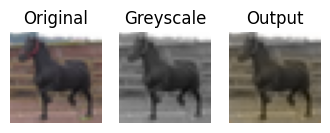

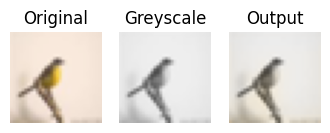

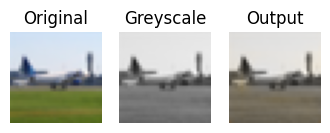

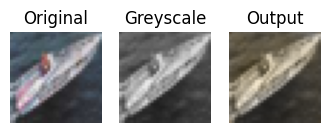

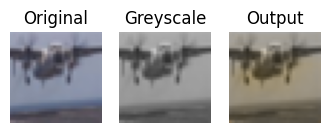

In [48]:
show_test_images(model_colorization, test_loader)

Experiments with different layer architecture. Add layers and more channels in deeper layer. 

In [35]:
model_colorization2 = CAE.ConvAutoencoder(1,[8,16,32],[32,16,2],1,1).to(device)
trainning_loss, validation_loss = train_model_colorization(model_colorization2, train_loader, val_loader)
print(f"Model colorization 2 with training loss: {trainning_loss[-1]}, validation loss: {validation_loss[-1]}")

model_colorization3 = CAE.ConvAutoencoder(1,[8,16,32,64],[64,32,16,2],1,1).to(device)
trainning_loss, validation_loss = train_model_colorization(model_colorization3, train_loader, val_loader)
print(f"Model colorization 3 with training loss: {trainning_loss[-1]}, validation loss: {validation_loss[-1]}")  

Model colorization 2 with training loss: 0.010183062837429487, validation loss: 0.010002795374020934
Model colorization 3 with training loss: 0.012091605846954, validation loss: 0.011903394293040038


Show test results for model 2. ([1,8,16,32],[32,16,2] architecture)

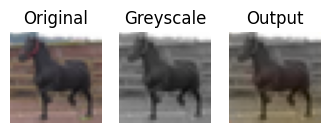

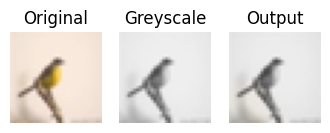

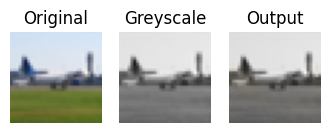

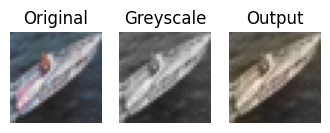

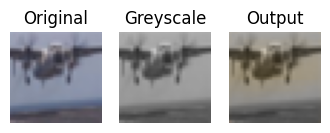

In [49]:
show_test_images(model_colorization2, test_loader)

Show test results for model 3. ([1,8,16,32,64],[64,32,16,2] architecture)

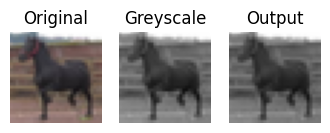

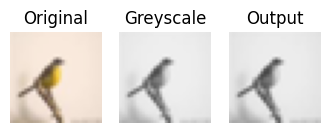

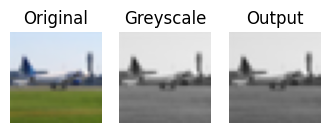

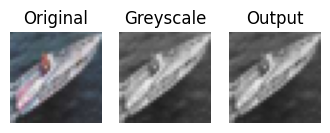

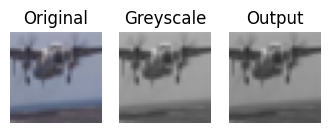

In [50]:
show_test_images(model_colorization3, test_loader)

From above expirenments, The second model 2 with [1,8,16,32],[32,16,2] architeture perform the best. One more layer ([1,8,16,32,64],[64,32,16,2]) is not helping, and it even worse then [1,8,16],[16,2] arcitecture. Perhaps, it is because the size of the latent space. In model 3, the latent representation in shape of [64,2,2]. In model 2, it is [34,4,4].